In [88]:
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy import optimize
from scipy import stats
from sklearn.neighbors import NearestNeighbors
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSTool as LT 

In [232]:
objdct = dict()
intSigma = 7
strRoot = 'Sigma' + str(intSigma)+ '/Expand123/'
for j in os.listdir(strRoot):
    if j.endswith('.dmp'):
        objData = LT.LAMMPSData(strRoot+ str(j),1,4.05, LT.LAMMPSGlobal)
        objHex = objData.GetTimeStepByIndex(-1)
        objHex.ReadInDefectData(strRoot + str(j[:-3]) + 'dfc')
        objdct[j] = objHex
#print(objHex.GetExteriorGrainAtomIDs(1))

In [223]:
objHex.GetInteriorGrainAtomIDs(1)[1000:1015]

[9.0, 13.0, 14.0, 15.0]

In [231]:
lstTJIDs = objHex.GetGrainBoundary(1).GetAtomIDs()
#lstTJIDs = objHex.GetExteriorGrainAtomIDs(1)[1000:1005]
arrPoints = objHex.GetAtomData()[:,[0,1,2,3,7]]
objNearest = NearestNeighbors(n_neighbors=13, radius=4.05
                             )
objNearest.fit(arrPoints[:,1:4])
fltMaxPE = -3.36 
lstNewIDs = lstTJIDs
setTJIDs = set()
lstTJCopy = lstTJIDs[:]
intCounter = 0
lstStartIDs = lstTJIDs
lstAllIDs = []
i = 0
while len(lstNewIDs) > 0 and i < 100:
    lstNewIDs = Loop(lstStartIDs)
    lstStartIDs = lstNewIDs
    lstAllIDs.extend(lstNewIDs)
    i +=1
lstAddition = list(set(lstAllIDs).difference(lstTJIDs))

KeyboardInterrupt: 

In [211]:
print(objHex.GetJunctionLine(1).GetAtomicDensity(), objHex.GetGrainBoundary(1).GetAtomicDensity())

0.05709850854303491 0.05698184655573062


In [83]:
def Loop(inlstIDs):
    lstNewIDs = []
    for x in inlstIDs:
        arrCentre1 = arrPoints[arrPoints[:,0] == x]
        lstNewIDs.extend(HigherPEPoints(arrCentre1[:,1:4]))
    return list(set(lstNewIDs).difference(inlstIDs))

In [205]:
def HigherPEPoints(arrPoint):
    lstReturn = []
   # lstIndices = objHex.FindSphericalAtoms(arrPoints[:, 0:4], arrPoint[0,1:4],4.05*np.sqrt(3)/2)
    lstIndices = objNearest.kneighbors(arrPoint,return_distance = False)[0]
    lstIDs = objHex.GetRows(lstIndices)[:,0].astype('int')
    arrPE = np.sort(objHex.GetColumnByIDs(lstIDs,7))#[1:-1]
    fltCurrentPE = np.mean(arrPE)
    if fltCurrentPE > -3.36:
        for i in lstIDs:
            arrCentre = objHex.GetAtomsByID([i])[:,1:4]
            #lstNewIndices = objHex.FindSphericalAtoms(arrPoints[:, 0:4], arrCentre[0],4.05*np.sqrt(3)/2)
            lstNewIndices = objNearest.kneighbors(arrCentre, return_distance = False)[0]
            lstNewIDs = objHex.GetRows(lstNewIndices)[:,0].astype('int')
            arrPE = np.sort(objHex.GetColumnByIDs(lstNewIDs,7))#[1:-1]
            fltNewPE = np.mean(arrPE)
            if fltNewPE >= fltCurrentPE:
                  lstReturn.append(int(i))
    return lstReturn

<IPython.core.display.Javascript object>


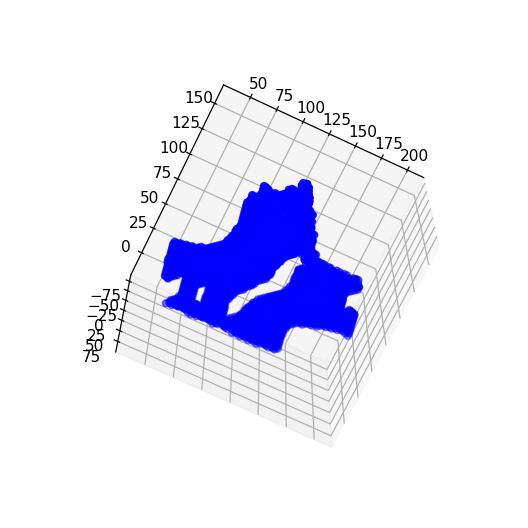

In [230]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(1)) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')
#ax.scatter(*tuple(zip(*objHex.GetAtomsByID(lstTJIDs)[:,1:4])), c='r')
#ax.scatter(*tuple(zip(*objHex.GetAtomsByID(lstAddition)[:,1:4])), c='b')
ax.scatter(*tuple(zip(*objHex.GetAtomsByID(lstAllIDs)[:,1:4])), c='b')
gf.EqualAxis3D(ax)
#plt.xlim(0, 360)
#plt.ylim(0,360)
plt.show()

In [ ]:
arr =np.argsort(lstLengths).astype('int')
arrLengths = np.array(lstLengths)[arr]
arrTJEnergy = np.array(lstTJEnergy)[arr]
print(arrTJEnergy)
plt.scatter(arrLengths, arrTJEnergy)

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(1)) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')
#plt.axis('equal')
lst = list(objdct.keys())
print(lst)
objHex = objdct[lst[4]]
ax.scatter(*tuple(zip(*objdct[lst[3]].GetAtomsByID(objdct[lst[3]].GetInteriorGrainAtomIDs(1))[:,1:4])))

In [ ]:
print(objHex.GetColumnNames())
lstLengths = []
lstTotalEnergy = []
lstExcessStrain =[]
lstLatticeAtoms = []
lstNonLatticeAtoms = []
lstLocalExcess = []
lstVStrain = []
for k in objdct.keys():
    intAtoms = objdct[k].GetNumberOfAtoms()
    lstLengths.append(np.linalg.norm(objdct[k].GetCellVectors()[0]))
   # lstLatticeAtoms = objdct[k].GetPTMAtomIDs()
    lstLatticeAtoms = []
    lstNonLatticeAtoms =objdct[k].GetNonPTMAtomIDs()
    #print(np.unique(objdct[k].GetColumnByName('GrainNumber')))
    for j in objdct[k].GetGrainLabels():
        if j > 0:
            lstLatticeAtoms.extend(objdct[k].GetInteriorGrainAtomIDs(j))
            lstNonLatticeAtoms.extend(objdct[k].GetExteriorGrainAtomIDs(j))     
    lstNonLatticeAtoms = list(np.unique(lstNonLatticeAtoms))
    lstLatticeAtoms = list(np.unique(lstLatticeAtoms))
    #lstNonLatticeAtoms =list(set(lstNonLatticeAtoms).difference(lstLatticeAtoms))
    fltMean = np.mean(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])
    fltSum = np.sum(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])
    lstExcessStrain.append(np.sum(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])+3.36*len(lstLatticeAtoms))
    #lstExcessStrain.append(np.sum(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7]))
    lstLocalExcess.append(np.sum(objdct[k].GetAtomsByID(lstNonLatticeAtoms)[:,7])+3.36*len(lstNonLatticeAtoms))
    #lstLocalExcess.append(np.sum(objdct[k].GetColumnByName('c_pe1'))-lstExcessStrain[-1]+3.36*(intAtoms -len(lstLatticeAtoms)))
    lstVStrain.append(np.median(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,10]))
    #fltMean = np.mean(objdct[k].GetAtomsByID(lstLatticeAtoms)[:,7])
    #arrVals = stats.gamma.fit(objdct[k].GetPTMAtoms()[:,7])
    #fltMean = arrVals[1]
    lstTotalEnergy.append(np.sum(objdct[k].GetColumnByName('c_pe1')) -lstLocalExcess[-1])

In [ ]:
fig = plt.figure
plt.scatter(lstLengths, lstVStrain)

In [ ]:
objHex.GetGrainLabels()

In [ ]:
arrVals = stats.gamma.fit(objdct[k].GetPTMAtoms()[:,7])
print(arrVals, arrVals[1]+arrVals[2])
plt.hist(objdct[k].GetPTMAtoms()[:,7],200)
plt.hist(objdct[k].GetNonPTMAtoms()[:,7],200)
plt.ylim([0,500])
print(np.median(objdct[k].GetPTMAtoms()[:,7]), np.mean(objdct[k].GetPTMAtoms()[:,7]))

In [ ]:
def DirectProportion(l,a1):
    return a1*l
def LinearFit(l,a1,a0):
    return a0+a1*l
def CubicFit(l,a2,a1, a0):
    return a2*l**2 + a1*l +a0*np.log(l)
arr =np.argsort(lstLengths).astype('int')
arrLengths = np.array(lstLengths)[arr]
arrExcessStrain = np.array(lstExcessStrain)[arr]
arrLocalExcess = np.array(lstLocalExcess)[arr]
arrTotal = np.array(lstTotalEnergy)[arr]
arrVStrain = np.array(lstVStrain)[arr]
#plt.scatter(arrLengths,arrTotal)
#plt.ylim([-0.005,0.001])
fig = plt.figure()
plt.scatter(arrLengths, arrExcessStrain)
popt1, popv1 = optimize.curve_fit(LinearFit, arrLengths, arrExcessStrain)
arrFitted1 = LinearFit(arrLengths, *popt1)
plt.plot(arrLengths,arrFitted1)
print(popt1)
plt.show()
fig = plt.figure()
popt2, popv2 = optimize.curve_fit(LinearFit, arrLengths, arrLocalExcess)
arrFitted2 = LinearFit(arrLengths, *popt2)
plt.scatter(arrLengths, arrLocalExcess)
plt.plot(arrLengths,arrFitted2)
print(popt2)
plt.show()


In [ ]:
plt.scatter(arrLengths,arrStrain)
plt.show()

In [ ]:
###### print(arrFitted,popt2)

In [ ]:

popt, popv = optimize.curve_fit(CubicFit, lstLengths, lstTotalEnergy)
print(popt)
arrFitted = CubicFit(np.array(arrLengths), *popt)
arrC = np.polynomial.legendre.legfit(lstLengths, lstTotalEnergy,2)
np.polynomial.legendre.leg2poly(arrC)
print(-popt[0]/popt[1], np.sqrt(3)*4.05)

In [ ]:
plt.scatter(lstLengths, lstTotalEnergy)
plt.plot(arrLengths, arrFitted, c='r')
plt.xlabel('Simulation Cell Side Length in $\AA$')
plt.ylabel('Total Potential Energy in $eV$')
plt.title('Simulation Cells Consisting of Sigma ' + str(intSigma) + ' CSL Units')
plt.show()

In [ ]:
objData = LT.LAMMPSData('/home/paul/PythonLAMMPS/Hex222Sigma7.dmp',1,4.05, LT.LAMMPSGlobal)
objHex = objData.GetTimeStepByIndex(-1)
fltDatum = np.mean(objHex.GetColumnByName('c_pe1'))
print(fltDatum)

In [ ]:
intSigma = 7
objdct= dict()
#strDirectory = '/home/paul/csf3_scratch/Sigma' + str(intSigma) + '/'
strDirectory = '/home/paul/PythonLAMMPS/'
lstHexNames = ['122','133','233', '123','222' ]
for j in lstHexNames:
    strFile = strDirectory + 'Hex' + str(j) + 'Sigma' + str(intSigma) + '.dmp'
    objData = LT.LAMMPSData(strFile,1,4.05, LT.LAMMPSGlobal)
    objHex = objData.GetTimeStepByIndex(-1)
   # objHex.ReadInDefectData(strFile[:-3] + 'dfc')
    objdct[j] = objHex

In [ ]:
print(objdct['123'].GetColumnNames())
np.sum(objdct['233'].GetAtomsByID(objdct['233'].GetLatticeAtomIDs())[:,7]) +3.360000236*len(objdct['233'].GetLatticeAtomIDs())

In [ ]:
def ExcessEnergies(objHex, lstGBs, lstTJs, lstGN, fltDatum = 3.360000023):
    fltGB = 0
    fltTJ = 0
    fltGN = 0
    for i in lstGBs:
        fltGB += objHex.GetGrainBoundary(i).GetTotalPE() + fltDatum*objHex.GetGrainBoundary(i).GetNumberOfAtoms()
    for j in lstTJs:
        fltTJ += objHex.GetJunctionLine(j).GetTotalPE() + fltDatum*objHex.GetJunctionLine(j).GetNumberOfAtoms()
    for k in lstGN:
        fltGN += np.sum(objHex.GetAtomsByID(objHex.GetGrainAtomIDs(k))[:,7]) + fltDatum*len(objHex.GetGrainAtomIDs(k))
    return [fltGB, fltTJ, fltGN]

In [ ]:
def GetTotalAtoms(objHex, intGrainNumber):
    intNumberOfAtoms = 0
    intNumberOfAtoms = len(objHex.GetGrainAtomIDs(intGrainNumber))
    for j in objHex.GetGrainBoundaryIDs():
        if intGrainNumber in objHex.GetGrainBoundary(j).GetAdjacentGrains():
            intNumberOfAtoms += objHex.GetGrainBoundary(j).GetNumberOfAtoms()
    for k in objHex.GetJunctionLineIDs():
        if intGrainNumber in objHex.GetJunctionLine(k).GetAdjacentGrains():
            intNumberOfAtoms += objHex.GetJunctionLine(k).GetNumberOfAtoms()
    return intNumberOfAtoms

In [ ]:
flt123 = np.sum(lst123)
flt122 = GetTotalAtoms(objHex123,2)*np.sum(lst122)/GetTotalAtoms(objHex122,2)
flt133 = GetTotalAtoms(objHex123,2)*np.sum(lst133)/GetTotalAtoms(objHex133,2)
flt233 = GetTotalAtoms(objHex123,2)*np.sum(lst233)/GetTotalAtoms(objHex233,2)
print(flt123-0.5*(flt122+flt133+flt233))

In [ ]:
fltTotalPE123 = np.sum(objdct['123'].GetAtomData()[:,7])
fltMinusOff = 0
for j in lstHexNames[1:]:
    fltMinusOff += 0.5*objdct['123'].GetNumberOfAtoms()*np.mean(objdct[j].GetAtomData()[:,7])
fltTotalPE123-fltMinusOff-0.5*fltDatum*objdct['123'].GetNumberOfAtoms()

In [ ]:
np.std(objdct['133'].GetAtomsByID(objdct['133'].GetLatticeAtomIDs())[:,7])

In [ ]:
print(lstHexNames)
for j in lstHexNames:
    print(objdct[j].GetNumberOfAtoms())
GetExcessEnergy(objdct['123'], fltDatum)

In [ ]:
def GetExcessEnergy(objGlobal, fltdatum):
    fltTotalPE = np.sum(objGlobal.GetAtomData()[:,7])
    fltExcess = fltTotalPE -fltdatum*objGlobal.GetNumberOfAtoms()
    return fltExcess/objGlobal.GetNumberOfAtoms()

In [ ]:
fltPerAtom =GetExcessEnergy(objdct['123'],fltDatum)-0.5*(GetExcessEnergy(objdct['122'],fltDatum)
                                             +GetExcessEnergy(objdct['133'],fltDatum)
                                             + GetExcessEnergy(objdct['233'],fltDatum))
print(fltPerAtom)

In [ ]:
GetExcessEnergy(objHex123,-3.36)-0.5*(GetExcessEnergy(objHex122, -3.36)+GetExcessEnergy(objHex133, -3.36)+(intAtoms123/intAtoms233)*GetExcessEnergy(objHex233, -3.36))

In [ ]:
(np.mean(objHex133.GetAtomsByID(objHex133.GetLatticeAtomIDs())[:,7])+3.36000002)*len(objHex133.GetLatticeAtomIDs())